In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
mn2 = 1000
prop_seed = 345
train_div = 0.5
back_callback_dir = "/home2/kalp_shah/neutrino/codes/ml/backup/dnn"
log_folder = "logs/dnn"
model_dir = "/home2/kalp_shah/neutrino/datasets/model/"
sig_epoch = {'test' : [], 'complete' : []}
model_max = Sequential()
max_sig = 0

2022-05-12 10:53:06.822426: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-12 10:53:06.822484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gnode32
2022-05-12 10:53:06.822495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gnode32
2022-05-12 10:53:06.822603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.95.1
2022-05-12 10:53:06.822638: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.95.1
2022-05-12 10:53:06.822646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.95.1
2022-05-12 10:53:06.823250: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [5]:
n2n2_cs = {500  : 5.13*1e-4,
           750  : 3.83*1e-4,
           #1000 : 3.99*1e-4,\
           1000 : 2.42*1e-4,
           1250 : 9.56*1e-5,
           1400 : 4.74*1e-5}

In [6]:
cs_lo_k = { 'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1}

br_ratio = {'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1}

cs_nmg = {  'ttbar':393.30,
            'wmp'  :7.865*1e4,
            'wpwm' :74.96,
            'zwpm' :14.28,
            'n2n2' :1}

cs_mg = {   'ttbar':5.883,
            'wmp':111.5,
            'wpwm':0.944,
            'zwpm':0.2381,
            'n2n2':n2n2_cs[mn2]}

In [7]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

# The cross sections are given in picobarn
cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [8]:
no_of_files = {'ttbar':0,
               'wmp':0,
               'wpwm':0,
               'zwpm':0,
               'n2n2':0
               }

In [9]:
df = []
for f in range(len(files)):
    con_df = []
    
    # The maximum file number 
    for i in range(1,80):
        try:
            if files[f] == 'n2n2':
                con_df.append(pd.read_csv('~/neutrino/datasets/n2n2_' + str(mn2) + '/' + files[f] + str(i) + '.csv'))
            else:
                con_df.append(pd.read_csv('~/neutrino/datasets/backgrounds/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [10]:
red_merging = {'ttbar':98159,
               'wmp':96494,
               'wpwm':97633,
               'zwpm':81076,
               'n2n2':int(1e5)
               }

In [11]:
total_events = []

for f in range(len(files)):
    total_events.append(no_of_files[files[f]] * red_merging[files[f]])

In [12]:
nf_print = pd.DataFrame([no_of_files.keys(),total_events]).T
nf_print.rename(columns = {0:'Process',1:'Number of Events'}, inplace = True)

In [13]:
nf_print.style.hide_index()

Process,Number of Events
ttbar,6085858
wmp,5886134
wpwm,4002953
zwpm,3648420
n2n2,6900000


In [14]:
dtset = pd.concat(df,ignore_index=True)
dtset['met'] = np.fabs(dtset['met'])

In [15]:
dtset = dtset\
       [dtset['ptl'] >= 120.0]\
       [dtset['ptj'] >= 120.0]\
       [dtset['etaj'] <=  2.0]\
       [dtset['etaj'] >= -2.0]

In [16]:
df_test = []
for df_sub in df:
    df_test.append(df_sub[int(len(df_sub)/2):])

In [17]:
dtset_test = pd.concat(df_test,ignore_index=True)
dtset_test['met'] = np.fabs(dtset_test['met'])

In [18]:
dtset_test = dtset_test\
            [dtset_test['ptl'] >= 120.0]\
            [dtset_test['ptj'] >= 120.0]\
            [dtset_test['etaj'] <=  2.0]\
            [dtset_test['etaj'] >= -2.0]

In [19]:
model = load_model('/home2/kalp_shah/neutrino/datasets/model/dnn_new_sig')

In [20]:
tot_pred = model.predict(dtset.T[:-2].T,batch_size = 4096,verbose=True)

4018/4018 [==============================] - 9s 2ms/step


In [22]:
pred_set = dtset.copy()
pred_set['pred'] = tot_pred

In [23]:
prob_sig = 0.98
L = 3000

In [24]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < prob_sig][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < prob_sig][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  1581250
Falsely identified signal (Flase Positive)      :  306
Correctly identified background (True Negative) :  10855473
Falsely identified background (False Negative)  :  4020025


In [25]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])/(len(pred_set[pred_set['pred'] >= prob_sig])))

Thus, the rate of correct signal prediction is :  0.9998065196553267


In [26]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])/(total_events[-1]))*L
print('n2n2',(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])),cs_corr['n2n2'])
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0][pred_set['type'] == i])/((total_events[i])))*L
    print(files[i],len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 1581250 0.242
ttbar 11 6538.845366086956
wmp 20 91227.27272727272
wpwm 107 692.2567850586979
zwpm 168 199.5908264705882


In [27]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 166.375
The number of background is : 1048.4612282968862
The significance is : 5.138210365983881


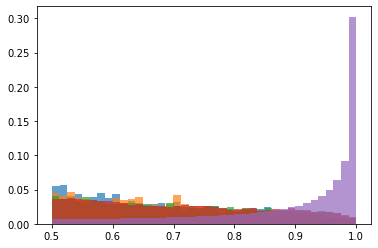

In [28]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.5]["pred"].values
    plt.hist(data,alpha=0.7,bins=40,weights=np.ones_like(data)/len(data))
plt.show()